# Image classification

## Plan
- seed = 7 
- All data exists in `dataset/images` directory.
- Separate 10% for test dataset.
    - Store test dataset under `dataset/test`
    - Store `inputDataset = (dataset - test)` under `dataset/input`
- Use Stratified 10-fold cross validation to divide `inputDataset` dataset into:
    - `train` datasets 
    - `val` datasets
- Train
    - Shuffle `train` dataset
    - Use `train` dataset to train your model, with validation_split=0.1
    - Evalaute in each epoch on `val` dataset

```
from sklearn.model_selection import train_test_split

x_input, x_test, y_input, y_test = train_test_split(xs, ys,
                                                    test_size=0.1,
                                                    random_state=0,
                                                    stratify=ys)

shuffle(x_input, y_input)

# X_train = 
# Y_train = 

validation_split = 0.1

for train_set, validation_set in rkf.split(x_input, y_input):
    X_train, X_val = x_input[train_set], x_input[validation_set]
    Y_train, Y_val = y_input[train_set], y_input[validation_set]

    model.fit(X_train, Y_train, epochs=n_epochs, verbose=0,
                              validation_split=validation_split)
                              
    model.evaluate(X_val, Y_val)
    
# Now run once after long tuning
model.evaluate(x_test, y_test)
```

## Imports

In [1]:
import os, sys, re, string, pathlib, random, io, time, glob
from collections import Counter, OrderedDict
from shutil import copyfile, rmtree

#import hecutils.resnet152 as resnet
from hecutils.resnet152 import ResNet152

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

import hecutils.data_utils as dt
import hecutils.scoring_utils as sc
import hecutils.plotting_utils as pt
import hecutils.common_utils as cm



import tensorflow as tf
from keras import backend as K
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from keras.layers import GRU, Bidirectional, LSTM, MaxPooling1D, Conv1D,Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers.core import Dropout, Flatten, Masking, ActivityRegularization
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import text
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Model
from keras import optimizers

# from fastText import load_model
from gensim.models import word2vec
from gensim.models.keyedvectors import KeyedVectors


import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from os import listdir
from os.path import isfile, join


%matplotlib inline 

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


None


## Set Keras to use Tensorflow GPU in the backend

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
from keras import backend as K

num_cores = 8
GPU=True
CPU = not GPU

if GPU:
    num_GPU = 1
    num_CPU = 8
if CPU:
    num_CPU = 8
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)

# Global variables

In [3]:
oasis_csv_path = "dataset/metadata/OASIS.csv"
oasis_images_src = "dataset/images/"
input_images_src = "dataset/input/"
test_images_src = "dataset/test/"
model_results_root_dir = "img_model/"

input_images_classified = "dataset/input-classified/"
test_images_classified = "dataset/test-classified/"

# ou can downlaod weights here: https://gist.github.com/flyyufelix/7e2eafb149f72f4d38dd661882c554a6
weights_path = "/home/elkhand/weights/resnet152_weights_tf.h5"

dataset_groups=["train", "val"]
classes = ["negative", "neutral", "positive"]

# fix random seed for reproducibility
seed = 7

test_size = 0.1

kfold_splits =  10

neutralLow = 3.0
neutralHigh = 5.0

nb_epochs = 100
patience = 10 # ReduceLROnPlateau has 5
batch_size = 32 # 32  
FC_SIZE = 1024
LAYERS_TO_UNFREEZE = 10
img_height = 224 # 299
img_width = 224  # 299

useF1Score = False
verbose=0 



## Creating test and input dataset, and `positive,neutral,negative` under each dataset

In [4]:
image_names, image_labels = dt.get_image_name_and_label(oasis_csv_path, neutralLow, neutralHigh)

imageNameToLabel = {}

for img_name,label in zip(image_names, image_labels):
    if img_name not in imageNameToLabel:
        imageNameToLabel[img_name] = label
    else:
        raise "There should not be images with same name: " + img_name + label    
        
image_names = np.array(image_names)
image_labels = np.array(image_labels)

input_x, test_x, input_y,  test_y = train_test_split(image_names, image_labels,
                                                    test_size=test_size,
                                                    random_state=seed,
                                                    stratify=image_labels)

print("Input data (to be used for model learning and validation) label distribution: \n",pt.get_label_count(input_y))
print()
print("Test data(never used for learning) label distribution: \n",pt.get_label_count(test_y))


# Delete input images dir
rmtree(input_images_src, ignore_errors=True)
os.makedirs(input_images_src)


# Delete test images dir
rmtree(test_images_src, ignore_errors=True)
os.makedirs(test_images_src)


# Copy input images into input dir, and test images into test dir
cm.copy_imgs_into(oasis_images_src, input_x, input_images_src)
cm.copy_imgs_into(oasis_images_src, test_x, test_images_src)



Input data (to be used for model learning and validation) label distribution: 
 OrderedDict([('negative', 147), ('neutral', 378), ('positive', 285)])

Test data(never used for learning) label distribution: 
 OrderedDict([('negative', 16), ('neutral', 42), ('positive', 32)])


config:
 {'img_height': 224, 'img_width': 224, 'kfold_splits': 10, 'batch_size': 32, 'nb_epochs': 100, 'useF1Score': False, 'verbose': 0}
Train size:  728
Val size:  82
Train label distribution:  OrderedDict([('negative', 132), ('neutral', 340), ('positive', 256)])
Val label distribution:  OrderedDict([('negative', 15), ('neutral', 38), ('positive', 29)])
Found 728 images belonging to 3 classes.
Found 82 images belonging to 3 classes.


/home/elkhand/anaconda3/envs/cs231n/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`



Starting fune-tuning
LAYERS_TO_UNFREEZE: 10 last layer id to freeze 713 total layers,  723
best_train_acc 0.6939655172413793
best_val_acc 0.65625


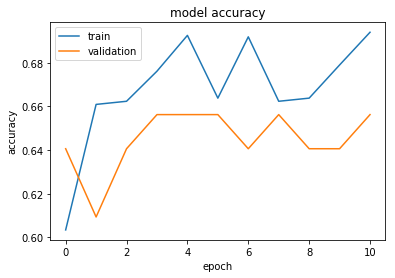

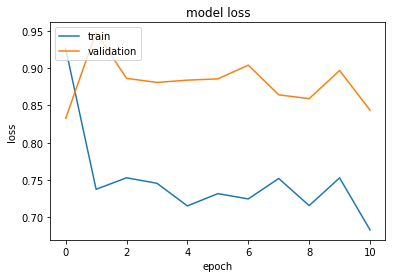

best_val_acc 0.65625
Train size:  728
Val size:  82
Train label distribution:  OrderedDict([('negative', 132), ('neutral', 340), ('positive', 256)])
Val label distribution:  OrderedDict([('negative', 15), ('neutral', 38), ('positive', 29)])
Found 728 images belonging to 3 classes.
Found 82 images belonging to 3 classes.

Starting fune-tuning
LAYERS_TO_UNFREEZE: 10 last layer id to freeze 713 total layers,  723
best_train_acc 0.36494252907818764
best_val_acc 0.171875


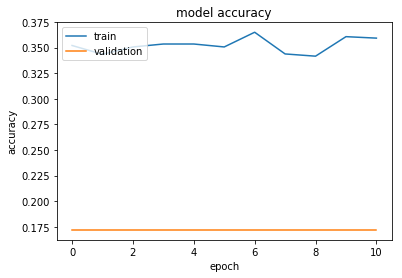

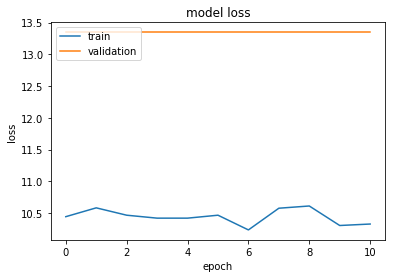

best_val_acc 0.171875
Train size:  728
Val size:  82
Train label distribution:  OrderedDict([('negative', 132), ('neutral', 340), ('positive', 256)])
Val label distribution:  OrderedDict([('negative', 15), ('neutral', 38), ('positive', 29)])
Found 728 images belonging to 3 classes.
Found 82 images belonging to 3 classes.

Starting fune-tuning
LAYERS_TO_UNFREEZE: 10 last layer id to freeze 713 total layers,  723
best_train_acc 0.8175287363172947
best_val_acc 0.71875


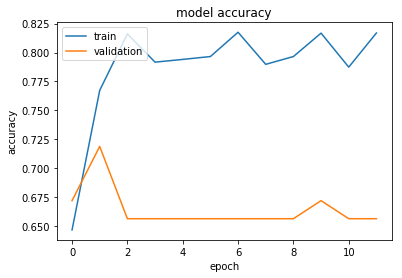

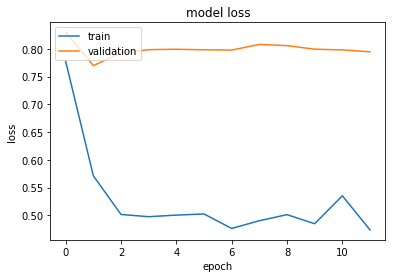

best_val_acc 0.71875
Train size:  728
Val size:  82
Train label distribution:  OrderedDict([('negative', 132), ('neutral', 340), ('positive', 256)])
Val label distribution:  OrderedDict([('negative', 15), ('neutral', 38), ('positive', 29)])
Found 728 images belonging to 3 classes.
Found 82 images belonging to 3 classes.

Starting fune-tuning
LAYERS_TO_UNFREEZE: 10 last layer id to freeze 713 total layers,  723
best_train_acc 0.8502906969813413
best_val_acc 0.65625


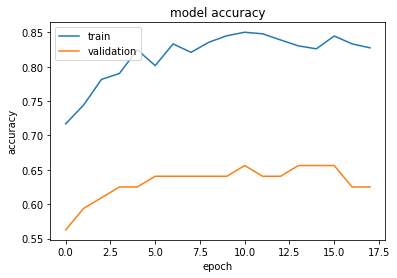

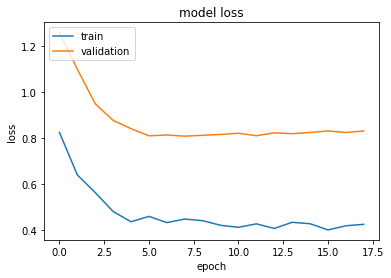

best_val_acc 0.65625
Train size:  728
Val size:  82
Train label distribution:  OrderedDict([('negative', 132), ('neutral', 340), ('positive', 256)])
Val label distribution:  OrderedDict([('negative', 15), ('neutral', 38), ('positive', 29)])
Found 728 images belonging to 3 classes.
Found 82 images belonging to 3 classes.

Starting fune-tuning
LAYERS_TO_UNFREEZE: 10 last layer id to freeze 713 total layers,  723
best_train_acc 0.49857954545454547
best_val_acc 0.59375


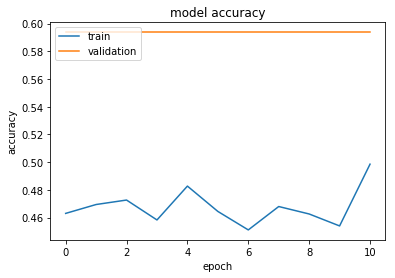

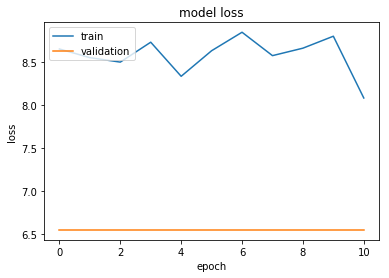

best_val_acc 0.59375
Train size:  729
Val size:  81
Train label distribution:  OrderedDict([('negative', 132), ('neutral', 340), ('positive', 257)])
Val label distribution:  OrderedDict([('negative', 15), ('neutral', 38), ('positive', 28)])
Found 729 images belonging to 3 classes.
Found 81 images belonging to 3 classes.

Starting fune-tuning
LAYERS_TO_UNFREEZE: 10 last layer id to freeze 713 total layers,  723


In [ ]:
# Instantiate the cross validator
skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)
cv_accuracies = []
cv_f1s = []
    
X = input_x
y = input_y
    
# Shuffe input data
X, y = shuffle(X,y)

def setup_to_finetune(model, useF1Score):
    """Freeze the bottom LAYERS_TO_FREEZE and retrain the remaining top layers.
  note: LAYERS_TO_FREEZE corresponds to the top 2 inception blocks in the inceptionv3 arch
  Args:
    model: keras model
    """    
    totalLayers = len(model.layers)
    lastFreezeLayer = totalLayers - LAYERS_TO_UNFREEZE
    print("LAYERS_TO_UNFREEZE:", LAYERS_TO_UNFREEZE, "last layer id to freeze", lastFreezeLayer, "total layers, ",totalLayers)
    for layer in model.layers[:lastFreezeLayer]:
        layer.trainable = False
    for layer in model.layers[lastFreezeLayer:]:
        layer.trainable = True
    model.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',\
                  metrics=cm.get_metrics(useF1Score))

def setup_to_transfer_learn(model, base_model, useF1Score):
    """Freeze all layers and compile the model"""    
    for layer in base_model.layers:
        layer.trainable = False
       
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', \
                  metrics=cm.get_metrics(useF1Score))
    print()

def add_new_last_layer(base_model, nb_classes):
    """Add last layer to the convnet
      Args:
        base_model: keras model excluding top
        nb_classes: # of classes
      Returns:
        new keras model with last layer
    """
    # 62,65,67% w/o reducing lr
    x = base_model.output
    #x = Dropout(0.5)(x)
    # convert MxNxC into 1xC
    x = GlobalAveragePooling2D()(x)
    x = Dense(FC_SIZE, activation='relu')(x) #new FC layer, random init
    output_layer = Dense(nb_classes, activation='softmax')(x) #new softmax layer
    model = Model(input=base_model.input, output=output_layer)

#     x = base_model.output
#     x = Flatten()(x)
#     x = Dropout(0.5)(x)
#     output_layer = Dense(nb_classes, activation='softmax', name='softmax')(x)
#     model = Model(inputs=base_model.input, outputs=output_layer)
    return model




def train(trainDir, valDir, config): 
    """Use transfer learning and fine-tuning to train a network on a new dataset"""     
    
    nb_classes = len(glob.glob(trainDir + "/*"))
    
    # this is a generator that will read pictures found in
    # subfolers of 'data/train', and indefinitely generate
    # batches of augmented image data
    isForTrain = True
    train_batches = cm.get_data_generator(trainDir, config, isForTrain)  
    

    # this is a similar generator, for validation data
    isForTrain = False
    validation_batches = cm.get_data_generator(valDir, config, isForTrain)  
        
    # setup model
    base_model = ResNet152(include_top=False, weights='imagenet')
    model = add_new_last_layer(base_model, nb_classes)

    # transfer learning
    setup_to_transfer_learn(model, base_model, config['useF1Score'])
    
    # monitor='val_loss', patience = 5 default
    reduce_lr = ReduceLROnPlateau()
    
    filepath = model_results_root_dir + "image.weights.best.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience)    
    callbacks_list = [ early_stopping, reduce_lr]  # , checkpoint

    # train the model on the new data for a few epochs
    history = model.fit_generator(
            train_batches,
            steps_per_epoch= train_batches.samples // config['batch_size'],
            epochs=5,
            validation_data=validation_batches,
            validation_steps= validation_batches.samples // config['batch_size'],
            shuffle=True,
            verbose=config['verbose'],
            #callbacks=callbacks_list,
            class_weight='auto')
    
    # fine-tuning
    print("Starting fune-tuning")
    setup_to_finetune(model, config['useF1Score'])
    
    # Add checkpointing to save best model
    #callbacks_list.append(checkpoint)
    history = model.fit_generator(
            train_batches,
            steps_per_epoch= train_batches.samples // config['batch_size'],
            epochs=config['nb_epochs'],
            validation_data=validation_batches,
            validation_steps= validation_batches.samples // config['batch_size'],
            shuffle=True,
            verbose=config['verbose'],
            callbacks=callbacks_list,
            class_weight='auto')
    return history, model


def conver_predictions_to_classes(predictions, label_map_from_train_gen):
    predictions = np.argmax(predictions, axis=-1) #multiple categories
    label_map_from_train_gen = dict((v,k) for k,v in label_map_from_train_gen.items()) #flip k,v
    predictions = [label_map_from_train_gen[k] for k in predictions]
    return predictions

def get_label_map_from_train_generator(config):
    trainDir = input_images_classified + "/" + "train" + "/"
    isForTrain = True
    config['batch_size'] = batch_size
    train_batches = cm.get_data_generator(trainDir, config, isForTrain)  
    return train_batches.class_indices

def get_trutch_labels_test_data(test_filenames):
    y_true = []
    for test_file_name in test_filenames:
        # 'negative/Ambulance 1.jpg'
        label, test_file_name = test_file_name.split("/")
        assert label == imageNameToLabel[test_file_name], \
                "test_file_name did not match: " + test_file_name + \
                "\t imageNameToLabel:" + imageNameToLabel[test_file_name]                                                    
        y_true.append(imageNameToLabel[test_file_name])
    return y_true

def evalaute_on_test_data(model, config):
    testDir = test_images_src
    print("testDir", testDir)
    isForTrain = False
    config['batch_size'] = 1
    
    # Divide input images into train and dev set, and each one into {negative, neutral, positive}
    isForTest = True
    dt.create_dataset("test", testDir, test_images_classified, test_x, test_y, isForTest)
    test_batches = cm.get_data_generator_for_test(test_images_classified, config) 

    results = model.evaluate_generator(test_batches, steps=test_batches.samples // config['batch_size'], verbose=1)
    print(model.metrics_names, results)
    
    predictions = model.predict_generator(test_batches, steps=test_batches.samples // config['batch_size'], verbose=1)
    
    label_map_from_train_gen = (get_label_map_from_train_generator(config))
    predictions = conver_predictions_to_classes(predictions, label_map_from_train_gen)
    
    test_filenames = test_batches.filenames
    y_true = get_trutch_labels_test_data(test_filenames)
    y_pred = predictions

    cnf_matrix = confusion_matrix(y_true, y_pred)
    print("cnf_matrix", cnf_matrix)
    titleOfConfusionMatrix = "Confusion Matrix based on InceptionResNetV2"
    pt.plot_confusion_matrix_from_labels(y_true, y_pred, titleOfConfusionMatrix)
    

def prepare_and_train(config):
    bestModel = None
    final_model_val_acc = -1
    for index, (train_indices, val_indices) in enumerate(skf.split(X, y)):
        print("Train size: ", len(train_indices))
        print("Val size: ", len(val_indices))

        X_train, X_val = X[train_indices], X[val_indices]
        y_train, y_val = y[train_indices], y[val_indices]

        print("Train label distribution: ", pt.get_label_count(y_train))
        print("Val label distribution: ", pt.get_label_count(y_val))

        # Divide input images into train and dev set, and each one into {negative, neutral, positive}
        isForTest = False
        dt.create_dataset("train", input_images_src, input_images_classified, X_train, y_train, isForTest)
        dt.create_dataset("val", input_images_src, input_images_classified, X_val, y_val, isForTest)

        trainDir = input_images_classified + "/" + "train" + "/"
        valDir = input_images_classified + "/" + "val" + "/"

        history, model = train(trainDir, valDir, config)
        
        pt.plot_model_accuracy(history, model_results_root_dir, useF1Score)
        best_val_acc = max(history.history['val_acc'])
        
        if best_val_acc > final_model_val_acc:
            bestModel = model
            final_model_val_acc = best_val_acc
        
        cv_accuracies.append(best_val_acc)
        print("best_val_acc", best_val_acc)
        if useF1Score:
            best_val_f1 = max(history.history['val_f1'])
            cv_f1s.append(best_val_f1)

    print("=========================================")
    print("Cross-validation val accuracy results: " , cv_accuracies)
    print("Cross-validation val accuracy results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_accuracies), np.std(cv_accuracies)))

    if useF1Score:
        print("\n","Cross-validation val f1 results: " , cv_f1s)
        print("Cross-validation val f1 results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_f1s), np.std(cv_f1s)))   
    
    # Evaluate Test data set
    evalaute_on_test_data(model, config)
    
    bestModel.save(model_results_root_dir + "/bestmodel-" + str(final_model_val_acc) + ".h5")


def get_config():
    conf = {}
    conf["img_height"] = img_height
    conf["img_width"] = img_width
    conf["kfold_splits"] = kfold_splits
    conf["batch_size"] = batch_size
    conf["nb_epochs"] = nb_epochs
    conf['useF1Score'] = useF1Score
    conf['verbose'] = verbose
    return conf    
    
def main():
    config = get_config()
    print("config:\n", config)
    prepare_and_train(config)
    # predict()
    # text_pre_processing("hello&nbsp;hi")
    pass

if __name__ == "__main__":
    # execute only if run as a script
    main()




## Experiments

### Model Architecture
Added ResNet152 -> GlobalAveragePooling2D() -> Dense()

Train only the last dense layer for 5 epochs, thn unfreeze few top N layers, and train 100 epochs

Experiments:

- Freeze all layers, except the last dense layer.
    - Overfitting, train > 0.9, val 0.55 - 0.75

```
Cross-validation val accuracy results:  [0.671875, 0.75, 0.609375, 0.640625, 0.71875, 0.65625, 0.640625, 0.78125, 0.703125, 0.6875]
Cross-validation val accuracy results: 0.69% (+/- 0.05%)
testDir dataset/test/
Found 90 images belonging to 3 classes.
90/90 [==============================] - 4s 47ms/step
['loss', 'acc'] [1.0616117291642115, 0.6555555555555556]
90/90 [==============================] - 20s 219ms/step
Found 731 images belonging to 3 classes.
cnf_matrix [[ 6  4  6]
 [ 6 24 12]
 [ 1  2 29]]
```

- Unfreeze all layers
    - cannot train, does not fit into memory


- Unfreeze top N layers
    - N = 10 
    - N = 30, , 
    - N = 50, ,